<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/MC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [285]:
class Particle():
  def __init__(self,position):
    self.position = np.array(position)

class System():
  def __init__(self,N,L,particle_radius):
    self.N = N
    self.L = L
    self.particle_radius = particle_radius

    self.particles = []
    for i in range(self.N):
      position = np.random.uniform(-self.L/2,self.L/2,3)
      self.particles.append(Particle(position))

    # Check and resolve overlaps
    for i in range(self.N):
        overlap = True
        while overlap:
            overlap = False
            for j in range(i):  # Only check previous particles
                distance = self.minimum_image_distance(self.particles[i].position, self.particles[j].position)
                if distance < 2 * self.particle_radius:  # Overlap detected
                    self.particles[i].position = np.random.uniform(0, self.L, 3)
                    overlap = True
                    break  # Restart check for this particle

    self.energy = self.calculate_energy()

  def minimum_image_distance(self,pos1,pos2):
    diff_vector = pos1 - pos2
    diff_vector = (diff_vector+(self.L/2))%self.L-(self.L/2)
    return np.linalg.norm(diff_vector)

  def calculate_energy(self):
    energy = 0
    for i in range(len(self.particles)):
      for j in range(len(self.particles)):
        if i < j:
          distance = self.minimum_image_distance(self.particles[i].position,self.particles[j].position)
          sigma = 2 * self.particle_radius
          epsilon = 1.0
          energy += 4*epsilon*((sigma/distance)**12 - (sigma/distance)**6)
    self.energy = energy
    return energy

class Dynamics():
  def __init__(self,N,L,particle_radius,nsteps,temperature):
    self.system = System(N,L,particle_radius)
    self.nsteps = nsteps
    self.T = temperature
    self.energies = []

  def run_dynamics(self):
    self.accepted = 0
    self.rejected = 0
    for i in range(self.nsteps):
      new_system = copy.deepcopy(self.system)
      rand_particle_index = np.random.randint(0,new_system.N)
      sigma = new_system.particle_radius * 2
      random_movement = np.random.uniform(-sigma,sigma)
      random_direction = np.random.randint(3) # 0=x, 1=y, 2=z
      new_system.particles[rand_particle_index].position[random_direction] = new_system.particles[rand_particle_index].position[random_direction] + random_movement
      if np.abs(new_system.particles[rand_particle_index].position[random_direction]) >= new_system.L/2:
        new_system.particles[rand_particle_index].position[random_direction] = (new_system.particles[rand_particle_index].position[random_direction]+(new_system.L/2))%new_system.L-(new_system.L/2)


      new_energy = new_system.calculate_energy()
      delta_E = new_energy - self.system.energy
      if delta_E < 0:
        self.system = new_system
        self.energies.append(new_energy)
        self.accepted += 1
      elif delta_E >= 0:
        boltzmann_factor = np.exp(-delta_E/self.T)
        rand = np.random.random()
        if rand <= boltzmann_factor:
          self.system = new_system
          self.energies.append(new_energy)
          self.accepted += 1
        elif rand > boltzmann_factor:
          self.energies.append(self.system.energy)
          self.rejected += 1



In [317]:
d = Dynamics(20,10,0.5,1000,0.6)
d.run_dynamics()


(-5.0, 5.0)

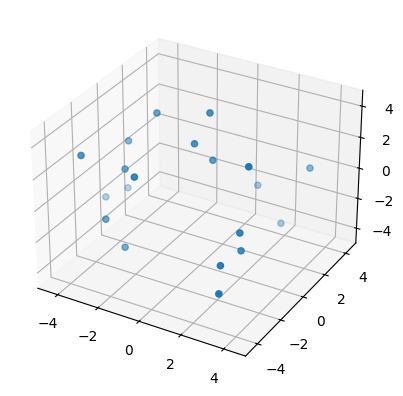

In [318]:
positions = [d.system.particles[i].position for i in range(len(d.system.particles))]
positions = np.array(positions)
x,y,z = positions.T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)

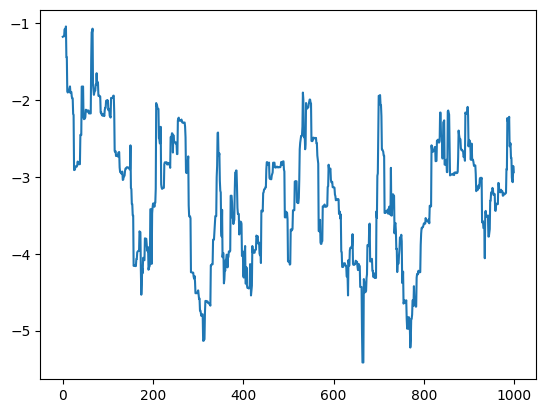

In [319]:
plt.plot(d.energies)